In [1]:
import pandas as pd # Pustaka untuk bekerja dengan data tabel (DataFrame)
import numpy as np  # Pustaka untuk operasi numerik yang efisien
import matplotlib.pyplot as plt # Pustaka untuk membuat grafik dasar
import seaborn as sns # Pustaka untuk membuat grafik statistik yang lebih menarik
from sklearn.preprocessing import StandardScaler # Untuk menyamakan skala fitur numerik
import joblib # Untuk menyimpan objek Python (model, scaler)

# Mengatur tampilan grafik agar lebih baik
sns.set_style('whitegrid')
plt.style.use('ggplot')

In [2]:
# Muat data dari folder raw
train_df_raw = pd.read_csv('../data/raw/train.csv')
test_df_raw = pd.read_csv('../data/raw/test.csv')

print("--- Data Train (5 baris pertama): ---")
print(train_df_raw.head()) # Menampilkan 5 baris pertama dari data training

print("\n--- Informasi Data Train: ---")
train_df_raw.info() # Menampilkan ringkasan informasi kolom (tipe data, jumlah non-null)

print("\n--- Missing values di Data Train: ---")
print(train_df_raw.isnull().sum()) # Menghitung jumlah nilai kosong per kolom di data training

# Simpan kolom 'Survived' dari train_df_raw dulu karena test_df tidak punya.
y_train_original = train_df_raw['Survived']

# Buat salinan DataFrame untuk dimodifikasi. 
train_df_temp = train_df_raw.drop('Survived', axis=1).copy() # Hapus 'Survived' dari train_df_temp
test_df_temp = test_df_raw.copy()

# Tambahkan kolom 'IsTrain' untuk membedakan baris training dan testing setelah digabung.
train_df_temp['IsTrain'] = True
test_df_temp['IsTrain'] = False

# Gabungkan data training dan testing. Ini dilakukan agar langkah preprocessing konsisten
# diterapkan pada kedua dataset (misalnya, membuat fitur baru, one-hot encoding).
combined_df = pd.concat([train_df_temp, test_df_temp], ignore_index=True)

print("\n--- Missing values di data gabungan (sebelum preprocessing): ---")
print(combined_df.isnull().sum()) # Cek missing values lagi setelah digabung

--- Data Train (5 baris pertama): ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0         

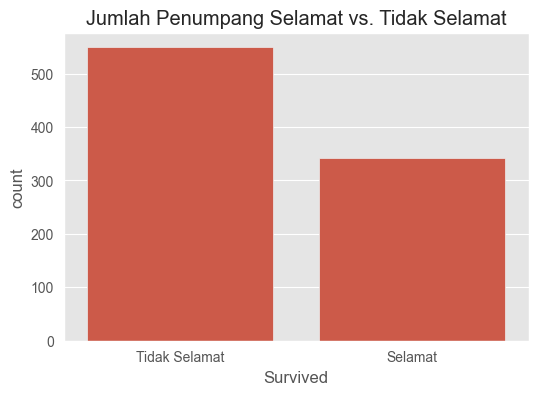

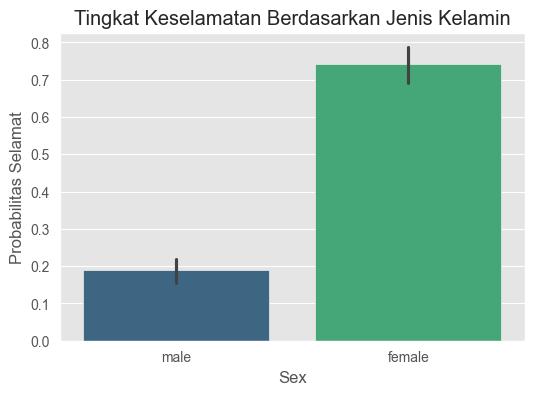

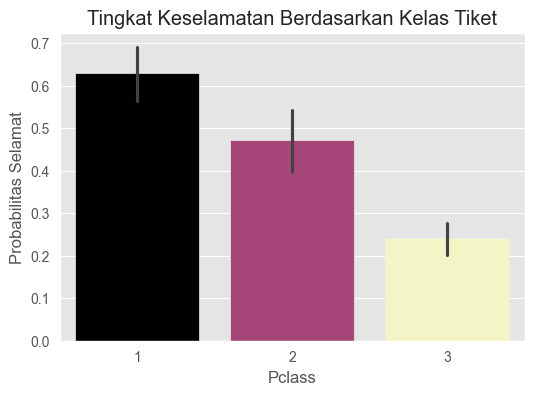

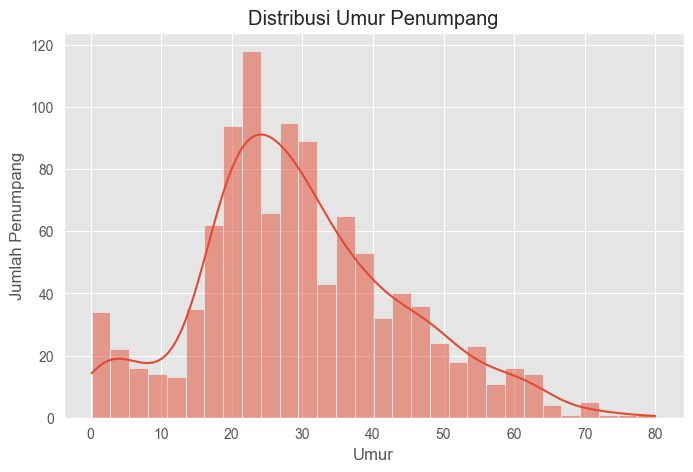

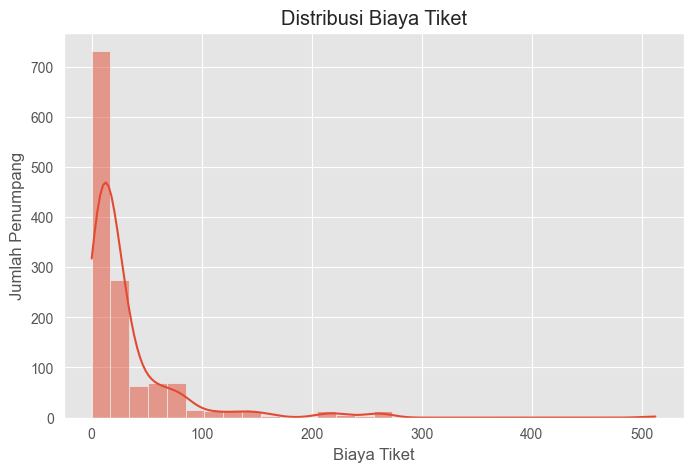

In [3]:
# Visualisasi Distribusi Survived (Target Kita)
# Ini menunjukkan berapa banyak penumpang yang selamat vs. tidak selamat.
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train_df_raw) # Menggunakan train_df_raw karena hanya di situ ada 'Survived'
plt.title('Jumlah Penumpang Selamat vs. Tidak Selamat')
plt.xticks([0, 1], ['Tidak Selamat', 'Selamat']) # Memberi label pada sumbu X
plt.show()

# Visualisasi Hubungan 'Sex' dengan 'Survived'
# Ini menunjukkan tingkat keselamatan berdasarkan jenis kelamin.
# Perbaikan: Tambahkan hue='Sex' dan legend=False untuk mengatasi FutureWarning.
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', hue='Sex', data=train_df_raw, palette='viridis', legend=False)
plt.title('Tingkat Keselamatan Berdasarkan Jenis Kelamin')
plt.ylabel('Probabilitas Selamat') # Label sumbu Y menunjukkan probabilitas selamat
plt.show()
# Insight: Biasanya perempuan punya tingkat keselamatan yang jauh lebih tinggi.

# Visualisasi Hubungan 'Pclass' (Kelas Tiket) dengan 'Survived'
# Ini menunjukkan tingkat keselamatan berdasarkan kelas tiket.
# Perbaikan: Tambahkan hue='Pclass' dan legend=False untuk mengatasi FutureWarning.
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', hue='Pclass', data=train_df_raw, palette='magma', legend=False)
plt.title('Tingkat Keselamatan Berdasarkan Kelas Tiket')
plt.ylabel('Probabilitas Selamat')
plt.show()
# Insight: Biasanya penumpang kelas 1 punya tingkat keselamatan tertinggi, diikuti kelas 2, dan terendah kelas 3.

# Visualisasi Distribusi Umur
# Ini menunjukkan sebaran umur penumpang di Titanic.
plt.figure(figsize=(8, 5))
# dropna() digunakan untuk menghilangkan nilai kosong (NaN) sementara saat membuat plot.
sns.histplot(combined_df['Age'].dropna(), kde=True, bins=30)
plt.title('Distribusi Umur Penumpang')
plt.xlabel('Umur')
plt.ylabel('Jumlah Penumpang')
plt.show()
# Insight: Anda bisa melihat di umur berapa penumpang paling banyak, dan apakah ada outlier.

# Visualisasi Distribusi Biaya Tiket ('Fare')
# Ini menunjukkan sebaran biaya tiket yang dibayarkan penumpang.
plt.figure(figsize=(8, 5))
sns.histplot(combined_df['Fare'].dropna(), kde=True, bins=30)
plt.title('Distribusi Biaya Tiket')
plt.xlabel('Biaya Tiket')
plt.ylabel('Jumlah Penumpang')
plt.show()
# Insight: Seringkali ada banyak penumpang dengan tiket murah, dan sedikit dengan tiket sangat mahal (distribusi miring).

In [4]:
# Cell 4: Penanganan Missing Values (Isi Data Kosong)

# Dapatkan median umur dari data train_df_raw ASLI
median_age_train = train_df_raw['Age'].median()
# Dapatkan modus pelabuhan naik dari data train_df_raw ASLI
# [0] karena .mode() bisa mengembalikan lebih dari satu modus jika frekuensinya sama.
mode_embarked_train = train_df_raw['Embarked'].mode()[0]
# Dapatkan median biaya tiket dari data train_df_raw ASLI
median_fare_train = train_df_raw['Fare'].median()

# Isi missing values di kolom 'Age', 'Embarked', 'Fare' pada combined_df
# Menggunakan cara yang disarankan Pandas untuk menghindari FutureWarning dan KeyError
# Kita cek dulu apakah kolomnya ada di DataFrame sebelum mencoba mengisi.
if 'Age' in combined_df.columns:
    combined_df['Age'] = combined_df['Age'].fillna(median_age_train)
else:
    print("Peringatan: Kolom 'Age' tidak ditemukan di combined_df.")

if 'Embarked' in combined_df.columns:
    combined_df['Embarked'] = combined_df['Embarked'].fillna(mode_embarked_train)
else:
    print("Peringatan: Kolom 'Embarked' tidak ditemukan di combined_df.")

if 'Fare' in combined_df.columns:
    combined_df['Fare'] = combined_df['Fare'].fillna(median_fare_train)
else:
    print("Peringatan: Kolom 'Fare' tidak ditemukan di combined_df.")

print("\n--- Missing values di data gabungan (setelah imputasi): ---")
print(combined_df.isnull().sum()) # Cek lagi, harusnya Age, Embarked, Fare sudah 0 missing values


--- Missing values di data gabungan (setelah imputasi): ---
PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
IsTrain           0
dtype: int64


In [5]:
# Fitur 'Title' dari 'Name'
# Mengekstrak gelar (Mr., Mrs., Miss, Master, dll.) dari kolom 'Name'
combined_df['Title'] = combined_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip() if pd.notnull(x) and isinstance(x, str) and ',' in x and '.' in x else 'Rare')

# Mapping (memetakan/mengelompokkan) gelar yang jarang atau mirip menjadi kategori yang lebih besar
title_mapping = {
    "Mme": "Mrs", "Mlle": "Miss", "Ms": "Miss", "Lady": "Mrs", "Countess": "Mrs",
    "Dona": "Mrs", "Sir": "Mr", "Don": "Mr", "Major": "Officer", "Col": "Officer",
    "Capt": "Officer", "Dr": "Officer", "Rev": "Officer", "Jonkheer": "Rare",
    "Mr": "Mr", "Mrs": "Mrs", "Miss": "Miss", "Master": "Master"
}
combined_df['Title'] = combined_df['Title'].replace(title_mapping)
# Menangani gelar yang mungkin tidak ada di mapping (ubah jadi 'Rare')
combined_df['Title'] = combined_df['Title'].apply(lambda x: x if x in title_mapping.values() else 'Rare')
print("\n--- Distribusi Fitur 'Title' baru: ---")
print(combined_df['Title'].value_counts())


# Fitur 'FamilySize': Jumlah anggota keluarga di kapal (diri sendiri + SibSp + Parch)
combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1
print("\n--- Distribusi Fitur 'FamilySize' baru: ---")
print(combined_df['FamilySize'].value_counts())

# Fitur 'IsAlone': Apakah penumpang bepergian sendirian (1 jika FamilySize == 1, 0 jika lainnya)
combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)
print("\n--- Distribusi Fitur 'IsAlone' baru: ---")
print(combined_df['IsAlone'].value_counts())

# Fitur 'Deck' dari 'Cabin': Mengambil huruf pertama dari nomor kabin
# 'U' jika informasi kabin kosong (Unkown)
combined_df['Deck'] = combined_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
print("\n--- Distribusi Fitur 'Deck' baru: ---")
print(combined_df['Deck'].value_counts())

# Fitur 'FarePerPerson': Biaya tiket per orang dalam keluarga
combined_df['FarePerPerson'] = combined_df['Fare'] / combined_df['FamilySize']
# Tangani kemungkinan nilai tak terhingga (inf) atau NaN jika ada pembagian oleh nol (walaupun harusnya tidak terjadi dengan +1)
combined_df['FarePerPerson'].replace([np.inf, -np.inf], np.nan, inplace=True)
# Imputasi NaN yang mungkin muncul setelah pembagian (misal jika FamilySize sangat besar dan Fare kecil)
combined_df['FarePerPerson'].fillna(combined_df['FarePerPerson'].median(), inplace=True)
print("\n--- Contoh Fitur 'FarePerPerson' (5 baris pertama): ---")
print(combined_df['FarePerPerson'].head())


--- Distribusi Fitur 'Title' baru: ---
Title
Mr         759
Miss       264
Mrs        200
Master      61
Officer     23
Rare         2
Name: count, dtype: int64

--- Distribusi Fitur 'FamilySize' baru: ---
FamilySize
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64

--- Distribusi Fitur 'IsAlone' baru: ---
IsAlone
1    790
0    519
Name: count, dtype: int64

--- Distribusi Fitur 'Deck' baru: ---
Deck
U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

--- Contoh Fitur 'FarePerPerson' (5 baris pertama): ---
0     3.62500
1    35.64165
2     7.92500
3    26.55000
4     8.05000
Name: FarePerPerson, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_24380\334318905.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['FarePerPerson'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_24380\334318905.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [6]:
# PassengerId dihapus karena ini hanya ID, tidak ada informasi untuk model
# errors='ignore' berarti jika kolom tidak ada (misal di test_df_raw tidak ada PassengerId, atau Cabin sudah dihapus), tidak akan error
combined_df.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'PassengerId'], axis=1, inplace=True, errors='ignore')
print("\n--- Kolom setelah dihapus: ---")
print(combined_df.columns)


--- Kolom setelah dihapus: ---
Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'IsTrain', 'Title',
       'FamilySize', 'IsAlone', 'Deck', 'FarePerPerson'],
      dtype='object')


In [7]:
# Identifikasi kolom kategorikal yang tersisa dan perlu di-encode
# Pclass meskipun angka, tapi lebih baik dianggap kategorikal (1, 2, 3 adalah kategori, bukan nilai yang berurutan)
categorical_cols = ['Sex', 'Embarked', 'Pclass', 'Title', 'Deck']

# One-Hot Encode menggunakan pd.get_dummies
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)
print("\n--- Contoh data setelah One-Hot Encoding (5 baris pertama): ---")
print(combined_df.head())
print("\n--- Kolom setelah One-Hot Encoding: ---")
print(combined_df.columns)


--- Contoh data setelah One-Hot Encoding (5 baris pertama): ---
    Age     Fare  IsTrain  FamilySize  IsAlone  FarePerPerson  Sex_male  \
0  22.0   7.2500     True           2        0        3.62500      True   
1  38.0  71.2833     True           2        0       35.64165     False   
2  26.0   7.9250     True           1        1        7.92500     False   
3  35.0  53.1000     True           2        0       26.55000     False   
4  35.0   8.0500     True           1        1        8.05000      True   

   Embarked_Q  Embarked_S  Pclass_2  ...  Title_Officer  Title_Rare  Deck_B  \
0       False        True     False  ...          False       False   False   
1       False       False     False  ...          False       False   False   
2       False        True     False  ...          False       False   False   
3       False        True     False  ...          False       False   False   
4       False        True     False  ...          False       False   False   

   Deck_C

In [8]:
numerical_cols_to_scale = ['Age', 'Fare', 'FamilySize', 'FarePerPerson']
scaler = StandardScaler() # Inisialisasi StandardScaler

# Fit scaler HANYA pada bagian data TRAINING (yang asli) dari combined_df
# Ini KRITIS untuk menghindari data leakage. Kita hanya boleh belajar dari data training.
X_train_for_scaler_fit = combined_df[combined_df['IsTrain'] == True][numerical_cols_to_scale]
scaler.fit(X_train_for_scaler_fit) # Mengajari scaler bagaimana mentransformasi data

# Terapkan transformasi (scaling) ke SELURUH combined_df (train dan test)
combined_df[numerical_cols_to_scale] = scaler.transform(combined_df[numerical_cols_to_scale])
print("\n--- Contoh data setelah Scaling Numerik (5 baris pertama, fitur numerik): ---")
print(combined_df[numerical_cols_to_scale].head())


--- Contoh data setelah Scaling Numerik (5 baris pertama, fitur numerik): ---
        Age      Fare  FamilySize  FarePerPerson
0 -0.565736 -0.502445    0.059160      -0.454798
1  0.663861  0.786845    0.059160       0.438994
2 -0.258337 -0.488854   -0.560975      -0.334757
3  0.433312  0.420730    0.059160       0.185187
4  0.433312 -0.486337   -0.560975      -0.331267


In [9]:
# Pisahkan kembali berdasarkan kolom 'IsTrain'
X_train_processed = combined_df[combined_df['IsTrain'] == True].drop('IsTrain', axis=1)
X_test_processed = combined_df[combined_df['IsTrain'] == False].drop('IsTrain', axis=1)

# y_train sudah disimpan di awal sebagai y_train_original
y_train = y_train_original

print("\n--- Bentuk X_train_processed (data training siap): ---")
print(X_train_processed.shape)
print("\n--- Bentuk X_test_processed (data testing siap): ---")
print(X_test_processed.shape)
print("\n--- Contoh data training siap (5 baris pertama): ---")
print(X_train_processed.head())


--- Bentuk X_train_processed (data training siap): ---
(891, 23)

--- Bentuk X_test_processed (data testing siap): ---
(418, 23)

--- Contoh data training siap (5 baris pertama): ---
        Age      Fare  FamilySize  IsAlone  FarePerPerson  Sex_male  \
0 -0.565736 -0.502445    0.059160        0      -0.454798      True   
1  0.663861  0.786845    0.059160        0       0.438994     False   
2 -0.258337 -0.488854   -0.560975        1      -0.334757     False   
3  0.433312  0.420730    0.059160        0       0.185187     False   
4  0.433312 -0.486337   -0.560975        1      -0.331267      True   

   Embarked_Q  Embarked_S  Pclass_2  Pclass_3  ...  Title_Officer  Title_Rare  \
0       False        True     False      True  ...          False       False   
1       False       False     False     False  ...          False       False   
2       False        True     False      True  ...          False       False   
3       False        True     False     False  ...          False

In [10]:
# Pastikan folder 'models' ada. (Kita sudah membuat .gitkeep, jadi harusnya sudah ada)
# import os # Sudah diimpor di Cell 1
# if not os.path.exists('../models'):
#     os.makedirs('../models') # Tidak perlu lagi karena sudah ada .gitkeep

# Simpan objek scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("Scaler disimpan ke models/scaler.pkl")

# Simpan daftar kolom fitur setelah preprocessing
# Ini memastikan API memproses data baru dengan urutan kolom yang benar
features_columns = X_train_processed.columns.tolist()
joblib.dump(features_columns, '../models/features_columns.pkl')
print("Daftar fitur kolom disimpan ke models/features_columns.pkl")

print("\nFitur akhir yang digunakan:", features_columns)

Scaler disimpan ke models/scaler.pkl
Daftar fitur kolom disimpan ke models/features_columns.pkl

Fitur akhir yang digunakan: ['Age', 'Fare', 'FamilySize', 'IsAlone', 'FarePerPerson', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Rare', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U']
